## 컬럼 명세
- GID: 격자번호
- DATE: 일자
- TIME: 시간(시)
- RIDE_DEMAND: 승차 수요 (Target Variable)
- ALIGHT_DEMAND: 하차 수요

**(주의) 하차수요가 아닌 승차수요를 예측하는 모델을 제출하여야 함**

# 0. Package & Data Load

In [ ]:
!pip install autogluon

In [10]:
#데이터 처리
import numpy as np
import pandas as pd

# 결측값 유무
import missingno as msno

import warnings #경고 미출력
warnings.filterwarnings('ignore')

# 시각화
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 10)
%matplotlib inline

import seaborn as sns

from autogluon.tabular import TabularDataset, TabularPredictor

In [33]:
train = pd.read_csv('/content/drive/MyDrive/hnu_contest/data/train_data_modified.csv')
test = pd.read_csv('/content/drive/MyDrive/hnu_contest/data/test_data_modified.csv')

# 1. EDA

In [ ]:
train.head()

,gid,DATE,TIME,RIDE_DEMAND,ALIGHT_DEMAND
0,다마9599,2023-06-01,5,1,0
1,다마9599,2023-06-01,6,2,5
2,다마9599,2023-06-01,7,2,7
3,다마9599,2023-06-01,8,3,12
4,다마9599,2023-06-01,9,2,31


In [34]:
#요일 변수 생성
#날짜 형으로 변환
train['DATE']=pd.to_datetime(train['DATE'])

#요일을 문자형으로 추출해 변수 생성
train['weekday']=train['DATE'].dt.strftime('%a')

In [35]:
test['DATE']=pd.to_datetime(test['DATE'])

#요일을 문자형으로 추출해 변수 생성
test['weekday']=test['DATE'].dt.strftime('%a')

In [ ]:
train.head()

,gid,DATE,TIME,RIDE_DEMAND,ALIGHT_DEMAND,weekday
0,다마9599,2023-06-01,5,1,0,Thu
1,다마9599,2023-06-01,6,2,5,Thu
2,다마9599,2023-06-01,7,2,7,Thu
3,다마9599,2023-06-01,8,3,12,Thu
4,다마9599,2023-06-01,9,2,31,Thu


In [ ]:
train['weekday'].unique()

array(['Thu', 'Fri', 'Sat', 'Sun', 'Mon', 'Tue', 'Wed'], dtype=object)

In [36]:
train['weekend'] = train['weekday'].isin(['Sat', 'Sun'])
train.head()

,gid,DATE,TIME,RIDE_DEMAND,ALIGHT_DEMAND,weekday,weekend
0,다마9599,2023-06-01,5,1,0,Thu,False
1,다마9599,2023-06-01,6,2,5,Thu,False
2,다마9599,2023-06-01,7,2,7,Thu,False
3,다마9599,2023-06-01,8,3,12,Thu,False
4,다마9599,2023-06-01,9,2,31,Thu,False


In [37]:
test['weekend'] = test['weekday'].isin(['Sat', 'Sun'])
test.head()

,gid,DATE,TIME,ALIGHT_DEMAND,weekday,weekend
0,다마9599,2023-06-24,5,0,Sat,True
1,다마9599,2023-06-24,6,1,Sat,True
2,다마9599,2023-06-24,7,0,Sat,True
3,다마9599,2023-06-24,8,1,Sat,True
4,다마9599,2023-06-24,9,5,Sat,True


In [ ]:
train['TIME'].unique()

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23,  0,  1])

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539490 entries, 0 to 539489
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   gid            539490 non-null  object        
 1   DATE           539490 non-null  datetime64[ns]
 2   TIME           539490 non-null  int64         
 3   RIDE_DEMAND    539490 non-null  int64         
 4   ALIGHT_DEMAND  539490 non-null  int64         
 5   weekday        539490 non-null  object        
 6   weekend        539490 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(3), object(2)
memory usage: 25.2+ MB


In [ ]:
len(train['gid'].unique())

367

In [ ]:
pd.DataFrame({'train':train.isnull().sum(),
              'test':test.isnull().sum()}).fillna('')

,train,test
ALIGHT_DEMAND,0,0.0
DATE,0,0.0
RIDE_DEMAND,0,
TIME,0,0.0
gid,0,0.0
weekday,0,0.0
weekend,0,0.0


In [ ]:
len(train)

539490

In [ ]:
target_col = 'RIDE_DEMAND'
train[target_col].value_counts().sort_index()

0       244380
1        42297
2        22634
3        13850
4        10029
         ...  
2458         1
2472         1
2477         1
2480         1
2485         1
Name: RIDE_DEMAND, Length: 1486, dtype: int64

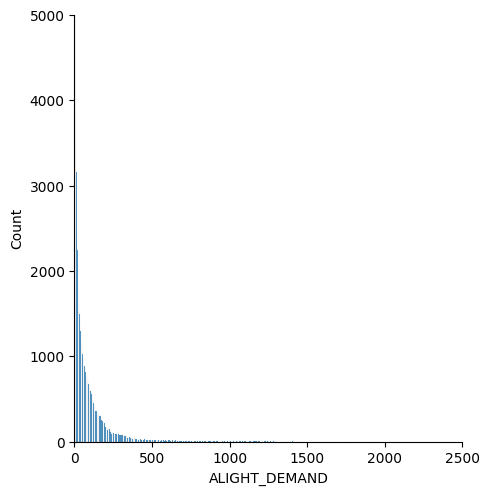

In [ ]:
#타깃변수(퇴근시간 승차인원)분포 시각화
sns.displot(train['ALIGHT_DEMAND'], kde=False )
plt.axis([0,2500,0,5000])
# plt.title'퇴근 시간 승차 인원 히스토그램')
plt.show()

In [ ]:
train.sort_values(by='ALIGHT_DEMAND', ascending=False)

,gid,DATE,TIME,RIDE_DEMAND,ALIGHT_DEMAND,weekday,weekend
235140,다바8917,2023-08-22,8,1089,3121,Tue,False
234447,다바8917,2023-07-13,8,1135,3017,Thu,False
234867,다바8917,2023-08-09,8,1114,3016,Wed,False
234846,다바8917,2023-08-08,8,1089,3010,Tue,False
234573,다바8917,2023-07-19,8,1093,3005,Wed,False
...,...,...,...,...,...,...,...
249321,다바8929,2023-07-21,14,0,0,Fri,False
249322,다바8929,2023-07-21,15,0,0,Fri,False
249323,다바8929,2023-07-21,16,0,0,Fri,False
249324,다바8929,2023-07-21,17,3,0,Fri,False


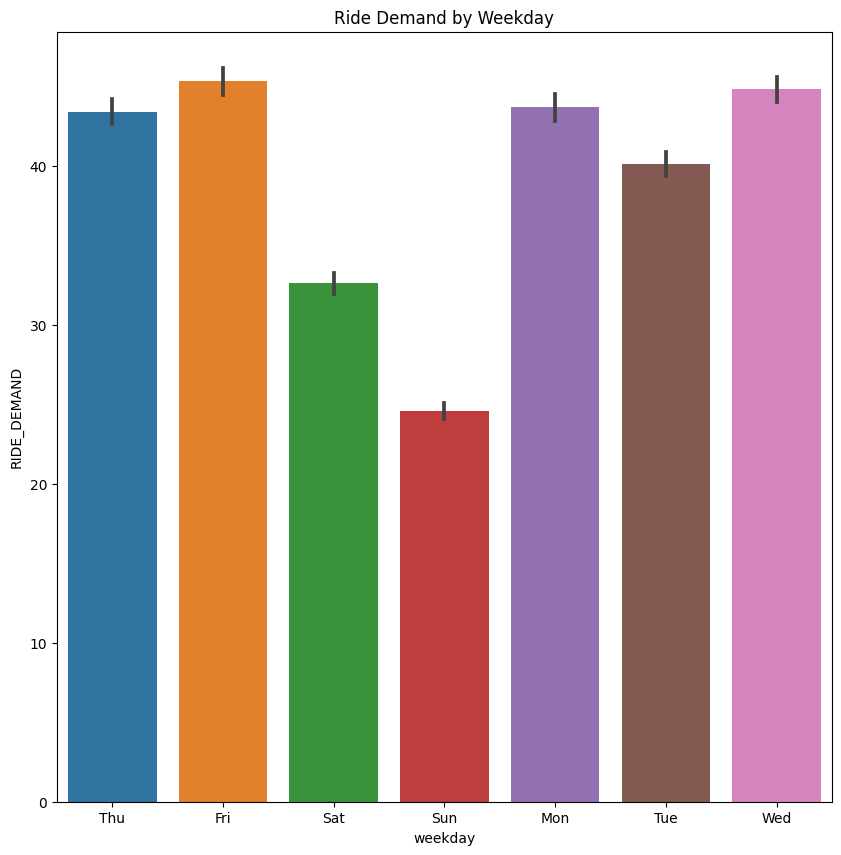

In [ ]:
sns.barplot(x='weekday', y='RIDE_DEMAND', data=train)
plt.title('Ride Demand by Weekday')
plt.show()

- 주말에 승하차 모두 감소하는 것을 볼 수 있음

In [38]:
#날짜에서 연휴 구분 함수
def holiday_function(x):
    #공휴일이라면 1을 반환
    if x in ['2023-06-06','2023-08-15','2023-09-28','2023-09-29','2023-09-30']:
        return 1
    else:
        #공휴일이 아닐경우는 0반환
        return 0

#모든 날짜에 반영
train['holidaty']=train['DATE'].apply(holiday_function)
test['holidaty']=test['DATE'].apply(holiday_function)

In [ ]:
train.head()

,gid,DATE,TIME,RIDE_DEMAND,ALIGHT_DEMAND,weekday,weekend,holidaty
0,다마9599,2023-06-01,5,1,0,Thu,False,0
1,다마9599,2023-06-01,6,2,5,Thu,False,0
2,다마9599,2023-06-01,7,2,7,Thu,False,0
3,다마9599,2023-06-01,8,3,12,Thu,False,0
4,다마9599,2023-06-01,9,2,31,Thu,False,0


In [ ]:
test.head()

,gid,DATE,TIME,ALIGHT_DEMAND,weekday,weekend,holidaty
0,다마9599,2023-06-24,5,0,Sat,True,0
1,다마9599,2023-06-24,6,1,Sat,True,0
2,다마9599,2023-06-24,7,0,Sat,True,0
3,다마9599,2023-06-24,8,1,Sat,True,0
4,다마9599,2023-06-24,9,5,Sat,True,0


# Modeling

In [39]:
train_df = TabularDataset(train)
test_df = TabularDataset(test)

label = 'RIDE_DEMAND'
eval_metric = 'mae'
time_limit = 3600*1 # 3600 * 1

predictor = TabularPredictor(
    label=label, eval_metric=eval_metric,
    path = '/content/drive/MyDrive/hnu_contest/data/'
).fit(train_df,
      presets='best_quality',
      num_stack_levels=3,
      time_limit=time_limit, num_gpus=1)

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=3, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "/content/drive/MyDrive/hnu_contest/data/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
Disk Space Avail:   3.13 GB / 16.11 GB (19.4%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    539490
Train Data Columns: 7
Label Column: RIDE_DEMAND
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (2485, 0, 39.19952, 106.84493)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify pr

In [ ]:
# # Leaderboard 확인
# leaderboard = predictor.leaderboard(train_df, silent = True, extra_metrics = ['rmse', 'mape'])
# leaderboard.head(10)

In [50]:
print(predictor.leaderboard(silent = True))
leaderboard.head()

                   model  score_val  pred_time_val     fit_time  \
0      LightGBMXT_BAG_L2  -4.461705    1436.187113  2316.258057   
1    WeightedEnsemble_L3  -4.461705    1436.206264  2316.282887   
2      LightGBMXT_BAG_L3  -4.471055    1798.868349  3050.152514   
3    WeightedEnsemble_L4  -4.471055    1798.877223  3050.167475   
4      LightGBMXT_BAG_L1  -4.533652     872.713407  1304.115715   
5    WeightedEnsemble_L2  -4.533652     872.745232  1310.928210   
6      LightGBMXT_BAG_L4  -4.742068    1897.720820  3320.161526   
7    WeightedEnsemble_L5  -4.742068    1897.731531  3320.177135   
8  KNeighborsUnif_BAG_L1 -14.537889      20.787064     3.506388   
9  KNeighborsDist_BAG_L1 -15.408487      11.044012     2.940424   

   pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  \
0              531.642630        1005.695529            2       True   
1                0.019151           0.024830            3       True   
2              362.681236         733.894457  

,model,score_test,root_mean_squared_error,mean_absolute_percentage_error,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT_BAG_L1,-32.843933,-66.394095,-4.737229e+16,-33.293855,6.167852,1.455733,36.376647,6.167852,1.455733,36.376647,1,True,1
1,WeightedEnsemble_L2,-32.843933,-66.394095,-4.737229e+16,-33.293855,6.177183,1.464764,36.392498,0.009331,0.009031,0.015852,2,True,2
2,LightGBMXT_BAG_L2,-52.469254,-102.377891,-7.615133e+16,-52.505923,8.543725,1.847524,76.641824,2.375872,0.391791,40.265177,2,True,3
3,WeightedEnsemble_L3,-52.469254,-102.377891,-7.615133e+16,-52.505923,8.554019,1.857500,76.655349,0.010295,0.009976,0.013526,3,True,4


In [51]:
# Feature Importance 확인
feature_importance = predictor.feature_importance(train_df)
feature_importance

These features in provided data are not utilized by the predictor and will be ignored: ['holidaty']
Computing feature importance via permutation shuffling for 6 features using 5000 rows with 5 shuffle sets...
	1929.46s	= Expected runtime (385.89s per shuffle set)
	1657.05s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
ALIGHT_DEMAND,40.051797,0.905567,3.133862e-08,5,41.916372,38.187221
gid,19.618635,0.825797,3.758154e-07,5,21.318963,17.918307
TIME,13.106489,0.562264,4.054451e-07,5,14.264199,11.948780
weekend,2.158887,0.134926,1.821316e-06,5,2.436702,1.881073
DATE,1.190028,0.100631,6.077913e-06,5,1.397229,0.982827
weekday,0.944362,0.099342,1.448021e-05,5,1.148908,0.739815


In [41]:
pred = predictor.predict(test_df)
test['RIDE_DEMAND'] = pred

test.to_csv('/content/drive/MyDrive/hnu_contest/data/submit.csv', index = False)
display(test)

,gid,DATE,TIME,ALIGHT_DEMAND,weekday,weekend,holidaty,RIDE_DEMAND
0,다마9599,2023-06-24,5,0,Sat,True,0,0.920205
1,다마9599,2023-06-24,6,1,Sat,True,0,1.662379
2,다마9599,2023-06-24,7,0,Sat,True,0,1.600883
3,다마9599,2023-06-24,8,1,Sat,True,0,2.542545
4,다마9599,2023-06-24,9,5,Sat,True,0,4.892101
...,...,...,...,...,...,...,...,...
161842,라바0421,2023-08-31,21,1,Thu,False,0,0.098508
161843,라바0421,2023-08-31,22,0,Thu,False,0,-0.022209
161844,라바0421,2023-08-31,23,0,Thu,False,0,-0.022209
161845,라바0421,2023-08-31,0,0,Thu,False,0,-0.072179


In [46]:
submit = pd.read_csv('/content/drive/MyDrive/hnu_contest/data/submit.csv')

columns_to_remove = ['weekday',	'weekend',	'holidaty']

submit = submit.drop(columns=columns_to_remove, axis=1)
submit.head()

,gid,DATE,TIME,ALIGHT_DEMAND,RIDE_DEMAND
0,다마9599,2023-06-24,5,0,0.920205
1,다마9599,2023-06-24,6,1,1.662379
2,다마9599,2023-06-24,7,0,1.600883
3,다마9599,2023-06-24,8,1,2.542545
4,다마9599,2023-06-24,9,5,4.892101


In [48]:
submit['RIDE_DEMAND'] = submit['RIDE_DEMAND'].round().astype(int)
submit.head()

,gid,DATE,TIME,ALIGHT_DEMAND,RIDE_DEMAND
0,다마9599,2023-06-24,5,0,1
1,다마9599,2023-06-24,6,1,2
2,다마9599,2023-06-24,7,0,2
3,다마9599,2023-06-24,8,1,3
4,다마9599,2023-06-24,9,5,5


In [49]:
submit = pd.DataFrame(submit)

desired_column_order = ['gid', 'DATE', 'TIME', 'RIDE_DEMAND', 'ALIGHT_DEMAND']
submit = submit[desired_column_order]


submit.to_csv('/content/drive/MyDrive/hnu_contest/data/submission.csv', index = False)
display(submit)

,gid,DATE,TIME,RIDE_DEMAND,ALIGHT_DEMAND
0,다마9599,2023-06-24,5,1,0
1,다마9599,2023-06-24,6,2,1
2,다마9599,2023-06-24,7,2,0
3,다마9599,2023-06-24,8,3,1
4,다마9599,2023-06-24,9,5,5
...,...,...,...,...,...
161842,라바0421,2023-08-31,21,0,1
161843,라바0421,2023-08-31,22,0,0
161844,라바0421,2023-08-31,23,0,0
161845,라바0421,2023-08-31,0,0,0
